Lab 3. Image Classification with CNN classifier

In [ ]:
import kagglehub
flowers_path = kagglehub.dataset_download('alxmamaev/flowers-recognition')

print('Data source import complete.')
print(flowers_path)


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Data source import complete.
/kaggle/input/flowers-recognition


In [ ]:
import os

# we first need to find the folder that contains the class subfolders (daisy, rose...)
print(os.listdir(flowers_path))

# the directory is usually something like this
data_dir = os.path.join(flowers_path, "flowers")
print("Using data_dir:", data_dir)
print("Classes folders:", os.listdir(data_dir))


['flowers']
Using data_dir: /kaggle/input/flowers-recognition/flowers
Classes folders: ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [ ]:
#Task 1. Dataset selection and description
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

data_dir = "/kaggle/input/flowers-recognition/flowers"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Fixing seed
torch.manual_seed(42)

train_size = int(0.7 * len(full_dataset))
test_size  = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", full_dataset.classes)
print("Number of classes:", len(full_dataset.classes))
print("Total images:", len(full_dataset))

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5
Total images: 4317


In [ ]:
# now, we check one batch
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)

Batch shape: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32])


In [ ]:
# Task 2. Preprocessing pipeline
import os
import kagglehub
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torch

# Download Flowers dataset
flowers_path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

# Path to the dataset (folder that contains class subfolders)
data_dir = os.path.join(flowers_path, "flowers")   # contains daisy/, rose/, etc.

# Define preprocessing pipeline for CNN input
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Fix random seed for reproducibility
torch.manual_seed(42)

train_size = int(0.7 * len(full_dataset))
test_size  = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", full_dataset.classes)
print("Number of classes:", len(full_dataset.classes))  # should be 5
print("Total images:", len(full_dataset))


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5
Total images: 4317


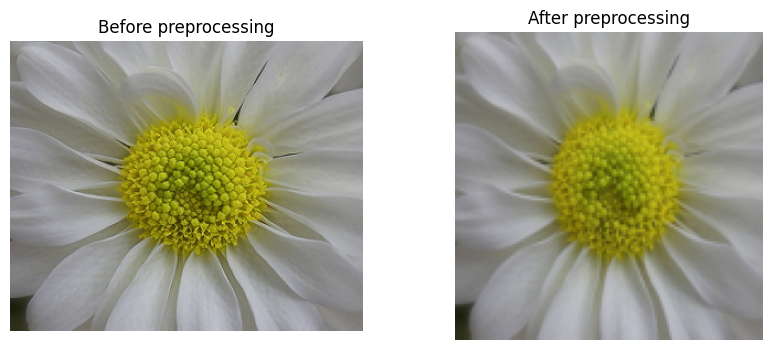

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load one raw image (without preprocessing)
sample_path, sample_label = full_dataset.samples[0]
raw_image = Image.open(sample_path).convert("RGB")

# Apply preprocessing to the same image
processed_image = transform(raw_image)

# Convert tensor back to numpy for visualization (unnormalize for display)
import numpy as np

def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

processed_image_vis = unnormalize(processed_image,
                                  mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# Plot before and after
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Before preprocessing")
plt.imshow(raw_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("After preprocessing")
plt.imshow(processed_image_vis.permute(1, 2, 0))
plt.axis("off")

plt.show()


In [ ]:
#before starting the task3, this can be used when training the binary model. This creates binary loaders without breaking the multiclass code.
from torch.utils.data import Subset, Dataset

class RemapLabels(Dataset):
    def __init__(self, subset, remap_dict):
        self.subset = subset
        self.remap = remap_dict
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return x, self.remap[int(y)]

binary_class_names = ["rose", "tulip"]  # you can change to any 2 flower classes

class_to_idx = full_dataset.class_to_idx
keep = [class_to_idx[name] for name in binary_class_names]
print("Binary keep indices:", keep)

binary_indices = [i for i, y in enumerate(full_dataset.targets) if y in keep]
binary_subset_raw = Subset(full_dataset, binary_indices)

remap = {keep[0]: 0, keep[1]: 1}
binary_dataset = RemapLabels(binary_subset_raw, remap)

torch.manual_seed(42)
train_size_b = int(0.7 * len(binary_dataset))
test_size_b  = len(binary_dataset) - train_size_b

train_dataset_bin, test_dataset_bin = random_split(binary_dataset, [train_size_b, test_size_b])

train_loader_bin = DataLoader(train_dataset_bin, batch_size=32, shuffle=True)
test_loader_bin  = DataLoader(test_dataset_bin, batch_size=32, shuffle=False)

print("Binary classes:", binary_class_names)
print("Binary total images:", len(binary_dataset))

# batch check (binary)
images_b, labels_b = next(iter(train_loader_bin))
print("Binary batch shape:", images_b.shape)
print("Binary labels shape:", labels_b.shape)
print("Binary labels unique:", sorted(set(labels_b.numpy().tolist())))


Binary keep indices: [2, 4]
Binary classes: ['rose', 'tulip']
Binary total images: 1768
Binary batch shape: torch.Size([32, 3, 128, 128])
Binary labels shape: torch.Size([32])
Binary labels unique: [0, 1]


In [ ]:
#Task 3. Baseline CNN Model
#defining baseline CNN architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # Fully connected layers
        # Input image size is 128x128 -> after two poolings: 32x32
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer depends on the number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Shape: [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # Shape: [B, 32, 32, 32]

        x = x.view(x.size(0), -1)              # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
#creating the model for the multiclass task (6 classes)
num_classes_multiclass = 6
model_multiclass = BaselineCNN(num_classes=num_classes_multiclass)

print(model_multiclass)

#binary version
num_classes_binary = 2
model_binary = BaselineCNN(num_classes=num_classes_binary)

print("\nBinary model (2 classes):")
print(model_binary)

BaselineCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

Binary model (2 classes):
BaselineCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
#counting the number of "trainable parameters"
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total trainable parameters:", count_parameters(model_multiclass))

print("Total trainable parameters (binary):", count_parameters(model_binary))

Total trainable parameters: 4200294
Total trainable parameters (binary): 4199778


In [ ]:
print("Classes:", full_dataset.classes)
print("Number of classes:", len(full_dataset.classes))

labels_list = [label for _, label in full_dataset.samples]
print("Min label:", min(labels_list))
print("Max label:", max(labels_list))


Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5
Min label: 0
Max label: 4


In [ ]:
#task 4. training procedure
#preparing device
import torch
import torch.nn as nn
import torch.optim as optim

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create the model for multiclass classification (6 classes)
num_classes_multiclass = 6
model_multiclass = BaselineCNN(num_classes=num_classes_multiclass).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()          # Suitable for multiclass classification
optimizer = optim.Adam(model_multiclass.parameters(), lr=0.001)

Using device: cpu


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model_multiclass, input_size=(32, 3, 128, 128))


Layer (type:depth-idx)                   Output Shape              Param #
BaselineCNN                              [32, 6]                   --
├─Conv2d: 1-1                            [32, 16, 128, 128]        448
├─MaxPool2d: 1-2                         [32, 16, 64, 64]          --
├─Conv2d: 1-3                            [32, 32, 64, 64]          4,640
├─MaxPool2d: 1-4                         [32, 32, 32, 32]          --
├─Linear: 1-5                            [32, 128]                 4,194,432
├─Linear: 1-6                            [32, 6]                   774
Total params: 4,200,294
Trainable params: 4,200,294
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 977.30
Input size (MB): 6.29
Forward/backward pass size (MB): 100.70
Params size (MB): 16.80
Estimated Total Size (MB): 123.79

In [ ]:
#training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch

def evaluate_model(model, test_loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro")
    rec = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    print("Test Accuracy :", acc)
    print("Test Precision:", prec)
    print("Test Recall   :", rec)
    print("Test F1-score :", f1)

    return acc, prec, rec, f1


In [ ]:
#training the baseline CNN
num_epochs = 10  # You can change this, but keep it fixed for all experiments
train_model(model_multiclass, train_loader, criterion, optimizer, num_epochs)
print("Evaluating Baseline CNN:")
acc, prec, rec, f1 = evaluate_model(model_multiclass, test_loader)

Epoch [1/10] - Loss: 1.3401, Accuracy: 0.4760
Epoch [2/10] - Loss: 0.9375, Accuracy: 0.6471
Epoch [3/10] - Loss: 0.6774, Accuracy: 0.7603
Epoch [4/10] - Loss: 0.3864, Accuracy: 0.8653
Epoch [5/10] - Loss: 0.1662, Accuracy: 0.9576
Epoch [6/10] - Loss: 0.0770, Accuracy: 0.9858
Epoch [7/10] - Loss: 0.0412, Accuracy: 0.9930
Epoch [8/10] - Loss: 0.0207, Accuracy: 0.9983
Epoch [9/10] - Loss: 0.0094, Accuracy: 0.9993
Epoch [10/10] - Loss: 0.0140, Accuracy: 0.9970
Evaluating Baseline CNN:
Test Accuracy : 0.6273148148148148
Test Precision: 0.6285403959361415
Test Recall   : 0.6304089887640822
Test F1-score : 0.6277882701360584


In [ ]:
#evaluating on the test set + metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro")
    rec = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    print("Test Accuracy :", acc)
    print("Test Precision:", prec)
    print("Test Recall   :", rec)
    print("Test F1-score :", f1)

    return acc, prec, rec, f1

In [ ]:
#Task 5. Error analysis
#collect predictions
import numpy as np
import torch

model_multiclass.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_multiclass(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Total test samples:", len(all_labels))

Total test samples: 1296


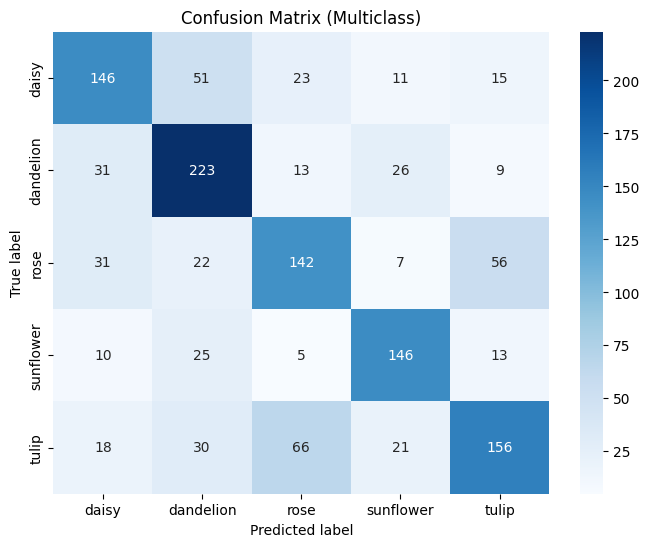

In [ ]:
#computing and plotting the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = full_dataset.classes  # ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Multiclass)")
plt.show()

In [ ]:
#to see correctly and uncorrectly classified examples
def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

Number of correctly classified samples: 813


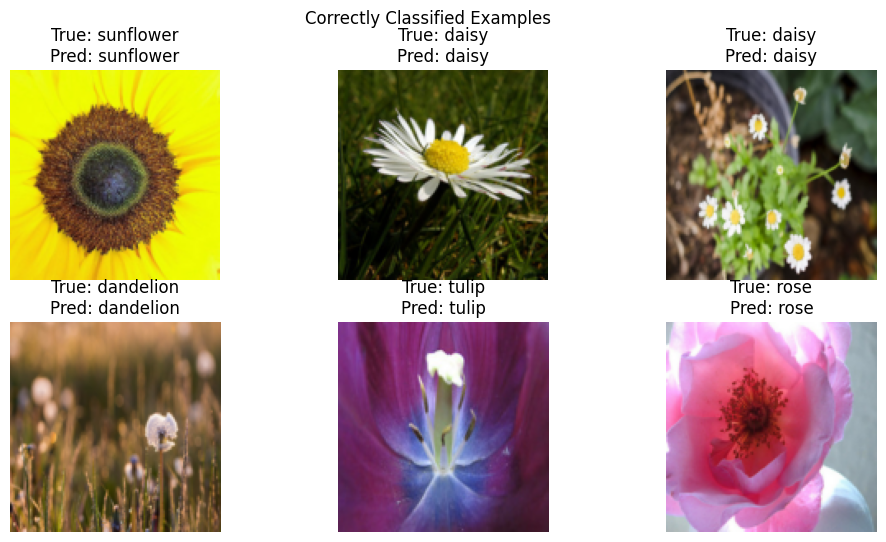

In [ ]:
#correctly classified
correct_indices = np.where(all_preds == all_labels)[0]
print("Number of correctly classified samples:", len(correct_indices))

# Show up to 6 correct examples
num_show = min(6, len(correct_indices))
plt.figure(figsize=(12, 6))

for i in range(num_show):
    idx = correct_indices[i]
    img = unnormalize(all_images[idx], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    plt.subplot(2, 3, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"True: {class_names[all_labels[idx]]}\nPred: {class_names[all_preds[idx]]}")
    plt.axis("off")

plt.suptitle("Correctly Classified Examples")
plt.show()

Number of misclassified samples: 483


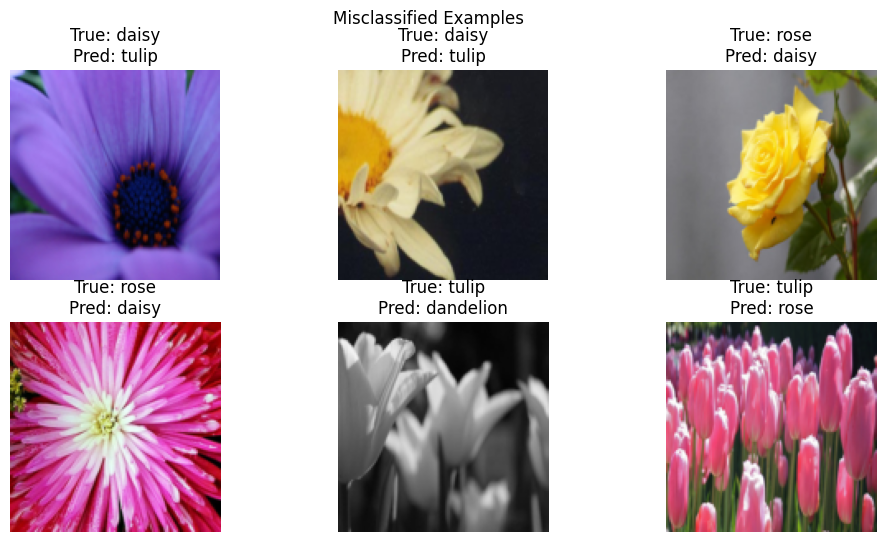

In [ ]:
#wrong classified images
incorrect_indices = np.where(all_preds != all_labels)[0]
print("Number of misclassified samples:", len(incorrect_indices))

# Show up to 6 incorrect examples
num_show = min(6, len(incorrect_indices))
plt.figure(figsize=(12, 6))

for i in range(num_show):
    idx = incorrect_indices[i]
    img = unnormalize(all_images[idx], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    plt.subplot(2, 3, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"True: {class_names[all_labels[idx]]}\nPred: {class_names[all_preds[idx]]}")
    plt.axis("off")

plt.suptitle("Misclassified Examples")
plt.show()

In [ ]:
#task 6. model improvement
#defining improved CNN architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()

        # Convolutional block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        # Convolutional block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Convolutional block 3 (new, increases model capacity)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)

        # Input image size: 128x128 -> after three poolings: 16x16
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [B, 16, 64, 64]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [B, 32, 32, 32]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # [B, 64, 16, 16]

        x = x.view(x.size(0), -1)                        # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
#creating improved model (multiclass)
num_classes_multiclass = 5
model_improved = ImprovedCNN(num_classes=num_classes_multiclass).to(device)

print(model_improved)
print("Total trainable parameters (improved model):", count_parameters(model_improved))

ImprovedCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)
Total trainable parameters (improved model): 4219653


In [ ]:
#train improved model with same training procedure
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_improved.parameters(), lr=0.001)

num_epochs = 10  # Keep the same number as for the baseline

train_model(model_improved, train_loader, criterion, optimizer, num_epochs)


Epoch [1/10] - Loss: 1.8346, Accuracy: 0.4406
Epoch [2/10] - Loss: 1.1791, Accuracy: 0.5210
Epoch [3/10] - Loss: 1.1231, Accuracy: 0.5412
Epoch [4/10] - Loss: 1.0644, Accuracy: 0.5687
Epoch [5/10] - Loss: 1.0445, Accuracy: 0.5872
Epoch [6/10] - Loss: 0.9785, Accuracy: 0.5998
Epoch [7/10] - Loss: 0.9342, Accuracy: 0.6326
Epoch [8/10] - Loss: 0.9219, Accuracy: 0.6369
Epoch [9/10] - Loss: 0.8700, Accuracy: 0.6541
Epoch [10/10] - Loss: 0.8326, Accuracy: 0.6660


In [ ]:
print("Evaluating Improved CNN:")
acc_imp, prec_imp, rec_imp, f1_imp = evaluate_model(model_improved, test_loader)

Evaluating Improved CNN:
Test Accuracy : 0.6628086419753086
Test Precision: 0.6656898013931337
Test Recall   : 0.6661143762173893
Test F1-score : 0.6522225964439022


In [ ]:
from torchinfo import summary

summary(model_improved, input_size=(32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedCNN                              [32, 5]                   --
├─Conv2d: 1-1                            [32, 16, 128, 128]        448
├─BatchNorm2d: 1-2                       [32, 16, 128, 128]        32
├─MaxPool2d: 1-3                         [32, 16, 64, 64]          --
├─Conv2d: 1-4                            [32, 32, 64, 64]          4,640
├─BatchNorm2d: 1-5                       [32, 32, 64, 64]          64
├─MaxPool2d: 1-6                         [32, 32, 32, 32]          --
├─Conv2d: 1-7                            [32, 64, 32, 32]          18,496
├─BatchNorm2d: 1-8                       [32, 64, 32, 32]          128
├─MaxPool2d: 1-9                         [32, 64, 16, 16]          --
├─Linear: 1-10                           [32, 256]                 4,194,560
├─Dropout: 1-11                          [32, 256]                 --
├─Linear: 1-12                           [32, 5]                   1,

In [ ]:
#task 7. training strategy comparison
#helper function
def train_model_with_history(model, train_loader, criterion, optimizer, num_epochs):
    model.train()

    history = {
        "loss": [],
        "accuracy": []
    }

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        history["loss"].append(epoch_loss)
        history["accuracy"].append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return history

In [ ]:
#Strategy A. Adam, learning rate = 0.001
# Create a fresh model instance
model_strategy_A = ImprovedCNN(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_A = torch.optim.Adam(model_strategy_A.parameters(), lr=0.001)

num_epochs = 10  # Keep this fixed for fair comparison

print("Training with Strategy A: Adam, lr = 0.001")
history_A = train_model_with_history(model_strategy_A, train_loader, criterion, optimizer_A, num_epochs)

# Evaluate Strategy A
print("Evaluation for Strategy A:")
acc_A, prec_A, rec_A, f1_A = evaluate_model(model_strategy_A, test_loader)

Training with Strategy A: Adam, lr = 0.001
Epoch [1/10] - Loss: 1.7851, Accuracy: 0.4247
Epoch [2/10] - Loss: 1.1737, Accuracy: 0.5141
Epoch [3/10] - Loss: 1.1142, Accuracy: 0.5528
Epoch [4/10] - Loss: 1.0685, Accuracy: 0.5693
Epoch [5/10] - Loss: 1.0407, Accuracy: 0.5866
Epoch [6/10] - Loss: 0.9771, Accuracy: 0.5955
Epoch [7/10] - Loss: 0.9658, Accuracy: 0.6114
Epoch [8/10] - Loss: 0.9346, Accuracy: 0.6197
Epoch [9/10] - Loss: 0.8701, Accuracy: 0.6428
Epoch [10/10] - Loss: 0.8618, Accuracy: 0.6518
Evaluation for Strategy A:
Test Accuracy : 0.6504629629629629
Test Precision: 0.6697986534071946
Test Recall   : 0.6504245803607777
Test F1-score : 0.6402353504569422


In [ ]:
#Strategy B. Adam, learning rate = 0.0001
# Create a fresh model instance
model_strategy_B = ImprovedCNN(num_classes=6).to(device)

optimizer_B = torch.optim.Adam(model_strategy_B.parameters(), lr=0.0001)

print("\nTraining with Strategy B: Adam, lr = 0.0001")
history_B = train_model_with_history(model_strategy_B, train_loader, criterion, optimizer_B, num_epochs)

# Evaluate Strategy B
print("Evaluation for Strategy B:")
acc_B, prec_B, rec_B, f1_B = evaluate_model(model_strategy_B, test_loader)


Training with Strategy B: Adam, lr = 0.0001
Epoch [1/10] - Loss: 1.3329, Accuracy: 0.4522
Epoch [2/10] - Loss: 1.0640, Accuracy: 0.5664
Epoch [3/10] - Loss: 0.9656, Accuracy: 0.6220
Epoch [4/10] - Loss: 0.9164, Accuracy: 0.6471
Epoch [5/10] - Loss: 0.8338, Accuracy: 0.6766
Epoch [6/10] - Loss: 0.7830, Accuracy: 0.7084
Epoch [7/10] - Loss: 0.7132, Accuracy: 0.7398
Epoch [8/10] - Loss: 0.6558, Accuracy: 0.7527
Epoch [9/10] - Loss: 0.6132, Accuracy: 0.7772
Epoch [10/10] - Loss: 0.5610, Accuracy: 0.8011
Evaluation for Strategy B:
Test Accuracy : 0.6790123456790124
Test Precision: 0.6786257488979948
Test Recall   : 0.6869484479664938
Test F1-score : 0.6788952876900594


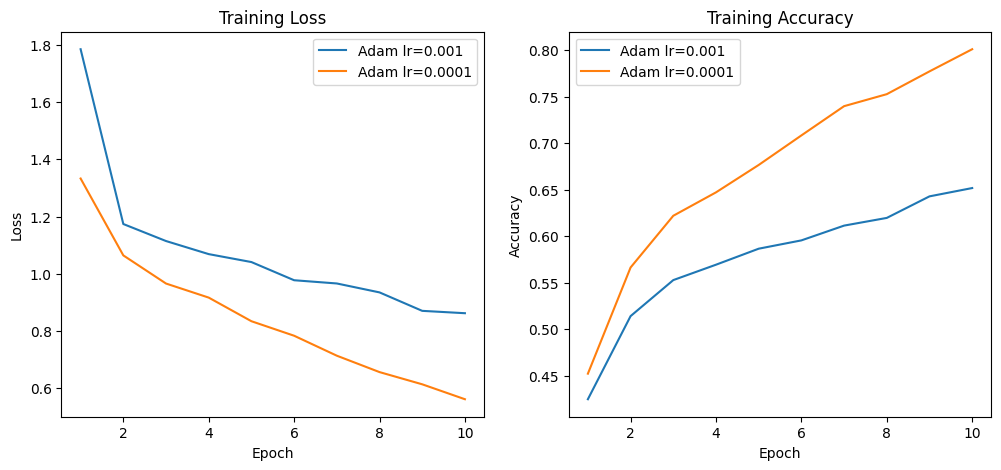

In [ ]:
#Plotting convergence curves (loss and accuracy)
import matplotlib.pyplot as plt

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_A["loss"], label="Adam lr=0.001")
plt.plot(epochs_range, history_B["loss"], label="Adam lr=0.0001")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_A["accuracy"], label="Adam lr=0.001")
plt.plot(epochs_range, history_B["accuracy"], label="Adam lr=0.0001")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
#Task 8. Final conclusion
import pandas as pd

results_table = pd.DataFrame({
    "Model": [
        "Baseline CNN",
        "Improved CNN",
        "Improved CNN (Strategy A: Adam lr=0.001)",
        "Improved CNN (Strategy B: Adam lr=0.0001)"
    ],
    "Accuracy": [acc, acc_imp, acc_A, acc_B],
    "Precision": [prec, prec_imp, prec_A, prec_B],
    "Recall": [rec, rec_imp, rec_A, rec_B],
    "F1-score": [f1, f1_imp, f1_A, f1_B]
})

results_table

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline CNN,0.627315,0.628540,0.630409,0.627788
1,Improved CNN,0.662809,0.665690,0.666114,0.652223
2,Improved CNN (Strategy A: Adam lr=0.001),0.650463,0.669799,0.650425,0.640235
3,Improved CNN (Strategy B: Adam lr=0.0001),0.679012,0.678626,0.686948,0.678895
